### Imports

In [2]:
import pyedflib
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy import signal
from imp import reload
import pandas as pd
import pywt
import readFiles
import databasePreparation
import preProcessing
import math
from scipy import ndimage, misc

from visualization import plotEogElectrodesSignal, plotVertHorEOG

### Reading Data

The data is read from an edf file, the EOG channels are extracted and the file is closed.

The edf file contains 272 channels, from all those channels, we are only interested in 4 of them:


| Channel Number | Channel Name | EOG Electrode |
| :---: | :------: | :------------------: |
| 256 | EXG1 | Left Electrode |
| 257 | EXG2 | Right Electrode |
| 258 | EXG3 | Down Electrode |
| 259 | EXG4 | Up Electrode |

In [3]:
# Reading the signals from the EDF file

edfFileName = 'C:/Users/Ricardo\source/enac-eog-analysis/data/EOG_EyeLink/RI02/Testdata0602.edf'
eyesData = readFiles.readEog(edfFileName)

freqSample = 2048

In [4]:
labelsCsvFile = 'C:/Users/Ricardo\source/enac-eog-analysis/data/EOG_EyeLink/RI02/labels_triggers_602.csv'

triggerCsv = readFiles.readCsvTriggerLabels(labelsCsvFile)

### Pre Processing

This section of the code is for signal processing like **noise filtering** and **baseline drift/wandering removal**.

For **baseline drift mitigation**, we used:
1. Scipy Detrend Function
2. 10th order Butterworth high-pass filter with optimal cut-off frequency described in literature: 0.04Hz

**Note:** The high-pass is useful for real time applications.

**Note:** The signal needs to be checked for baseline drift, because if it doesn't have it, then it is **unnecessary** to apply baseline drift mitigation.

In [ ]:
# Pre-processing of the signal using butterworth filter
# sos = signal.butter(10, 10, 'lp', fs=freqSample, output='sos')
# eyesDataFiltered = signal.sosfilt(sos, eyesData)
eyesDataFiltered = ndimage.median_filter(eyesData, size = 100)


In [ ]:
# Pre-processing: baseline wandering/drift mitigation
eyesDataFiltered2 = signal.detrend(eyesDataFiltered)

In [ ]:
# Pre-processing: baseline wandering/drift mitigation
sos2 = signal.butter(1, 0.04, 'highpass', fs=freqSample, output='sos')
eyesDataFiltered3 = signal.sosfilt(sos2, eyesDataFiltered)

### Ploting Example

Part of the electrode's signals that corresponds to calibration.

In [ ]:
calibrationPart = databasePreparation.getEogCalibrationPart(eyesDataFiltered2, triggerCsv)
calibrationPart = signal.detrend(calibrationPart)
labels = ['Left Electrode', 'Right Electrode', 'Down Electrode', 'Up Electrode']
plotEogElectrodesSignal(calibrationPart, labels=labels)

In [ ]:
calibrationPart2 = databasePreparation.getEogCalibrationPart(eyesDataFiltered3, triggerCsv)
labels = ['Left Electrode', 'Right Electrode', 'Down Electrode', 'Up Electrode']
plotEogElectrodesSignal(calibrationPart2, labels=labels)

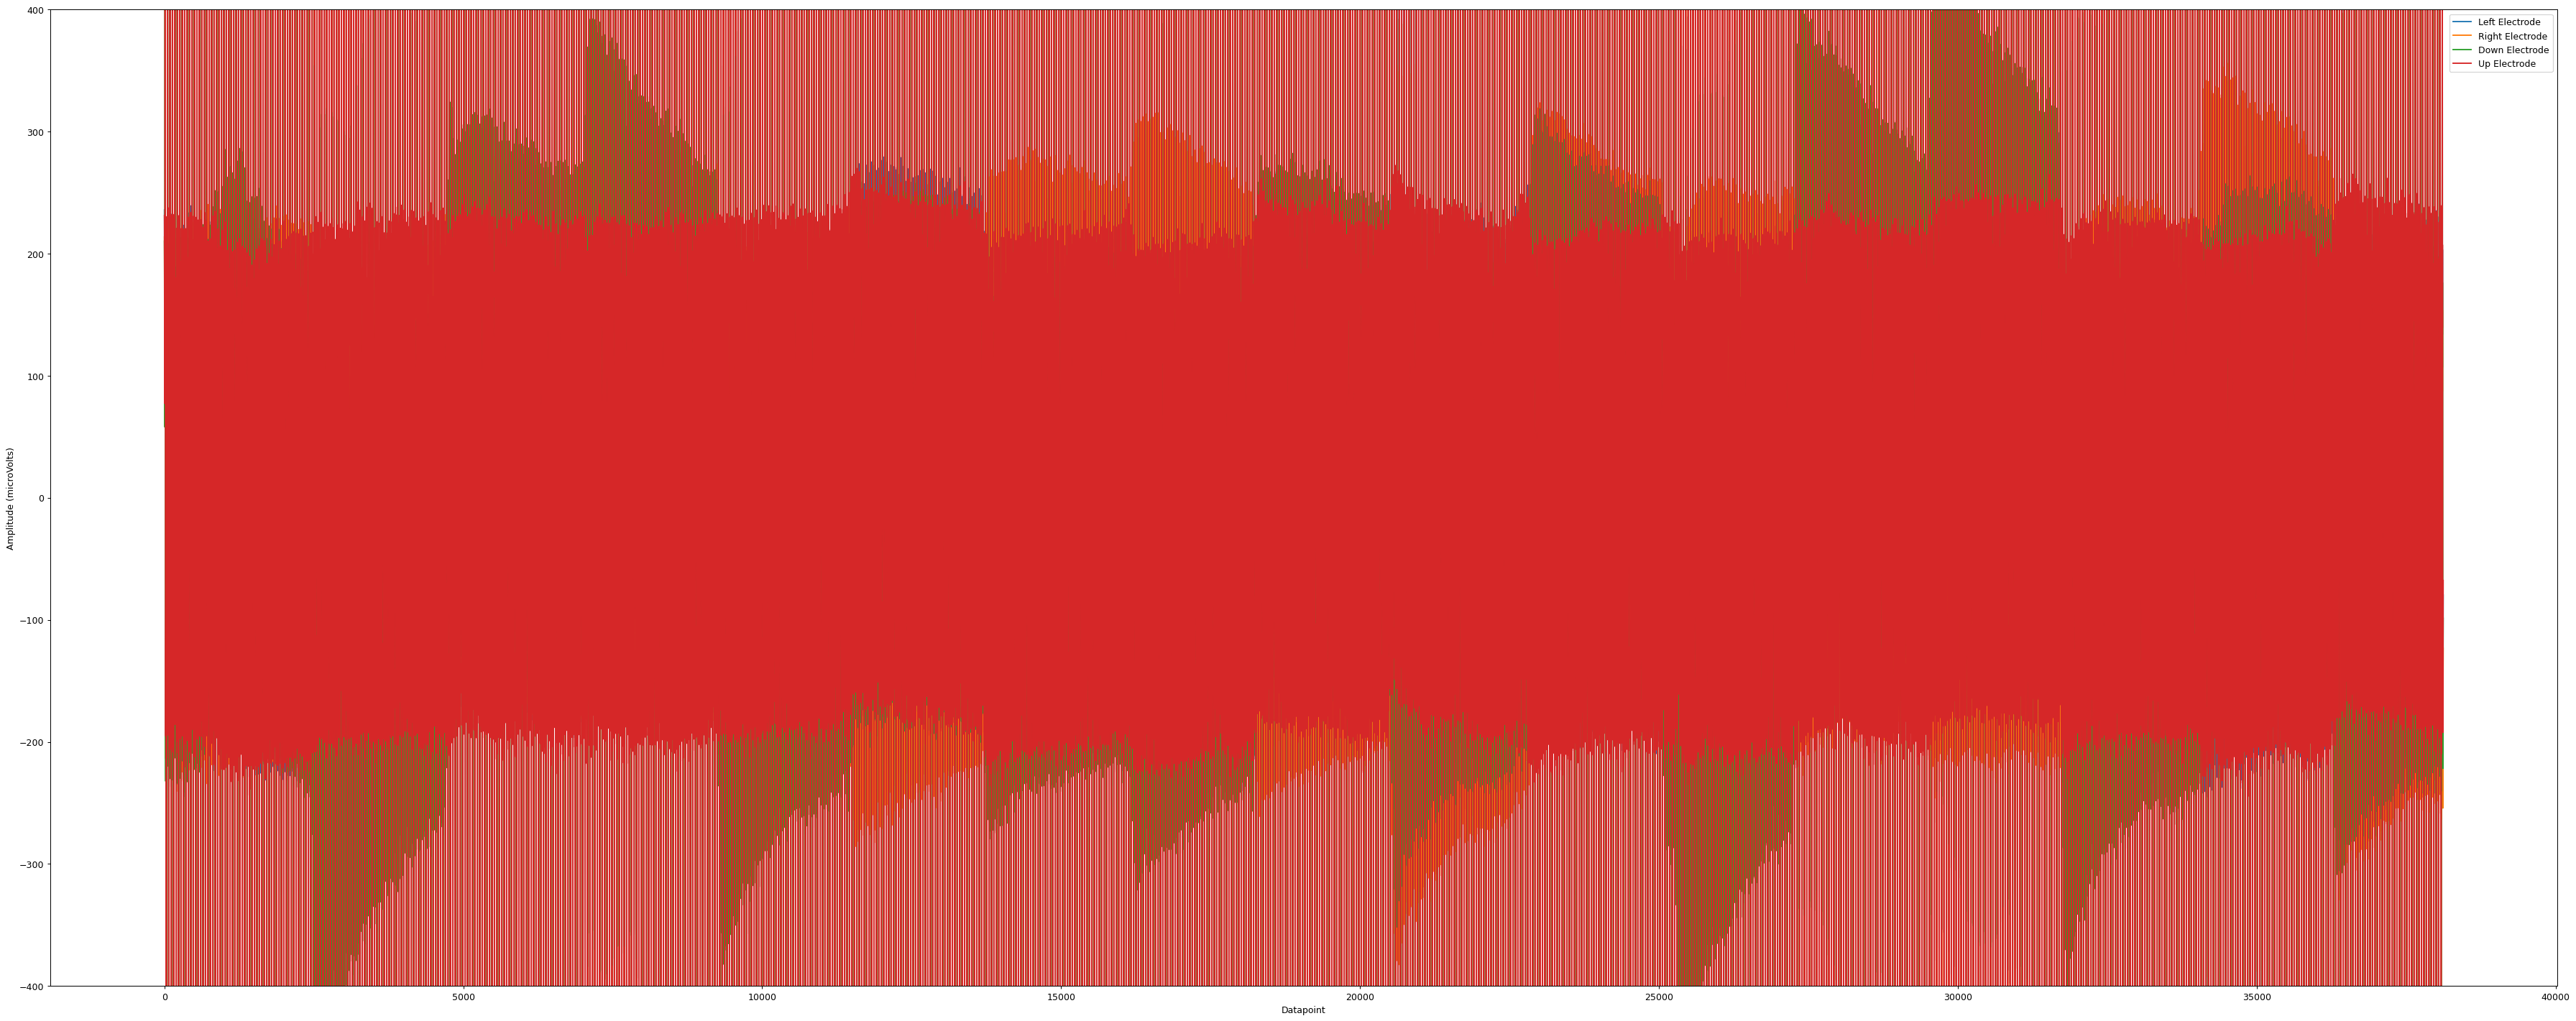

In [9]:
calibrationPart3 = databasePreparation.getEogCalibrationPart(eyesData, triggerCsv)
labels = ['Left Electrode', 'Right Electrode', 'Down Electrode', 'Up Electrode']
plotEogElectrodesSignal(calibrationPart3, labels=labels)

# Subtracting the signals

To analyze the signal, we must subtract the potencials from the Up and Down Electrode and the Left and Right Electrode.

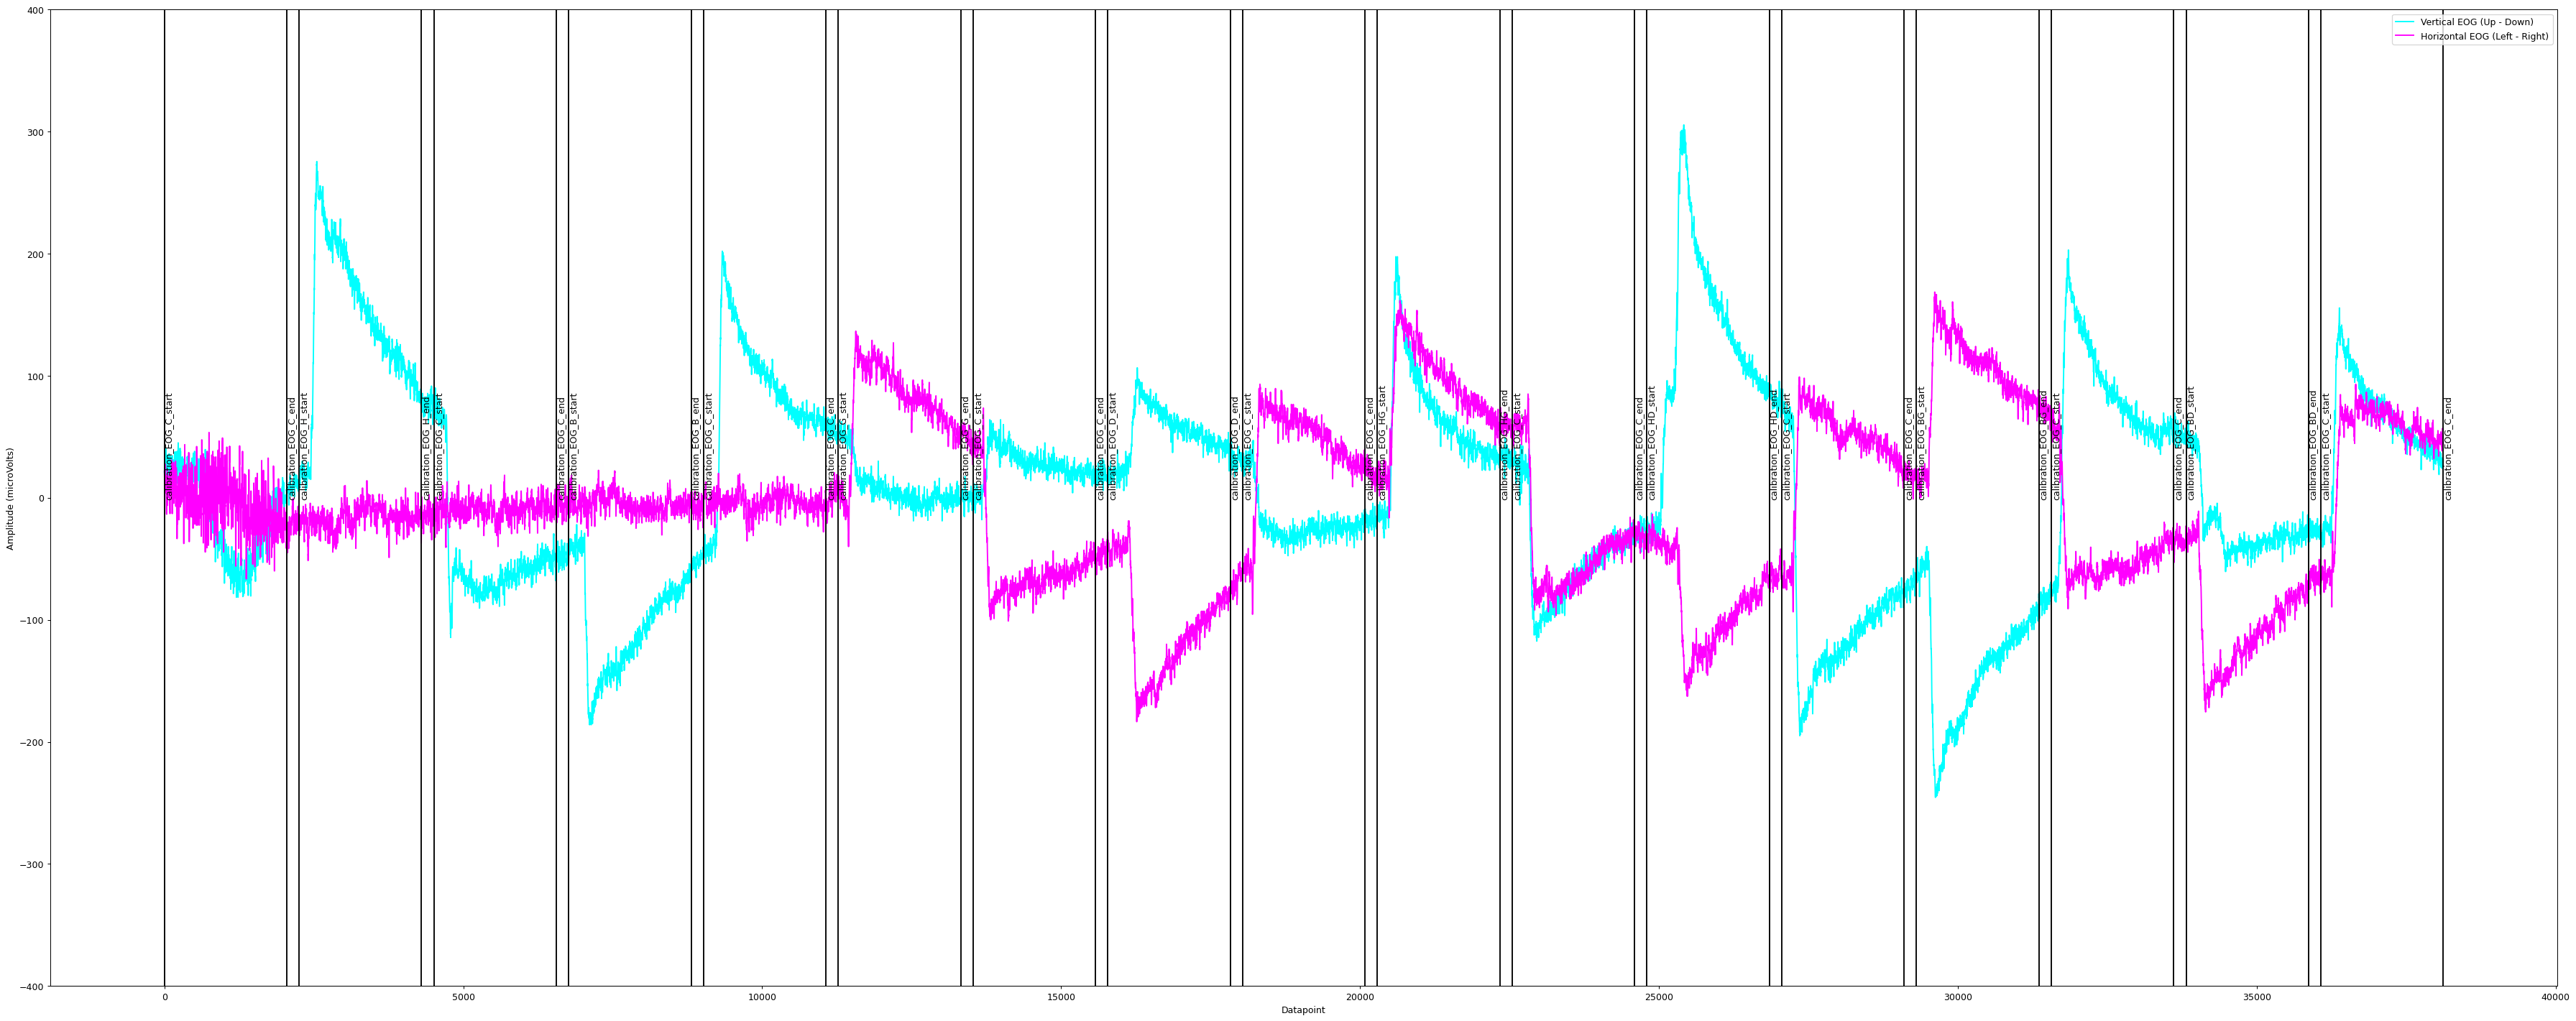

In [81]:

verticalEOG, horizontalEOG = preProcessing.electrodesToVertHori(calibrationPart2, 0, 1, 2, 3)
calStartArray, calEndArray = databasePreparation.getEogLabelIndexes(triggerCsv, 'calibration_EOG_C_start', 'calibration_EOG_C_end')
calibrationStart = calStartArray[0]
calibrationEnd = calEndArray[-1]
    
plotVertHorEOG(verticalEOG, horizontalEOG, triggerStart=calibrationStart, triggerEnd=calibrationEnd,  mode='both', triggerCsv=triggerCsv)


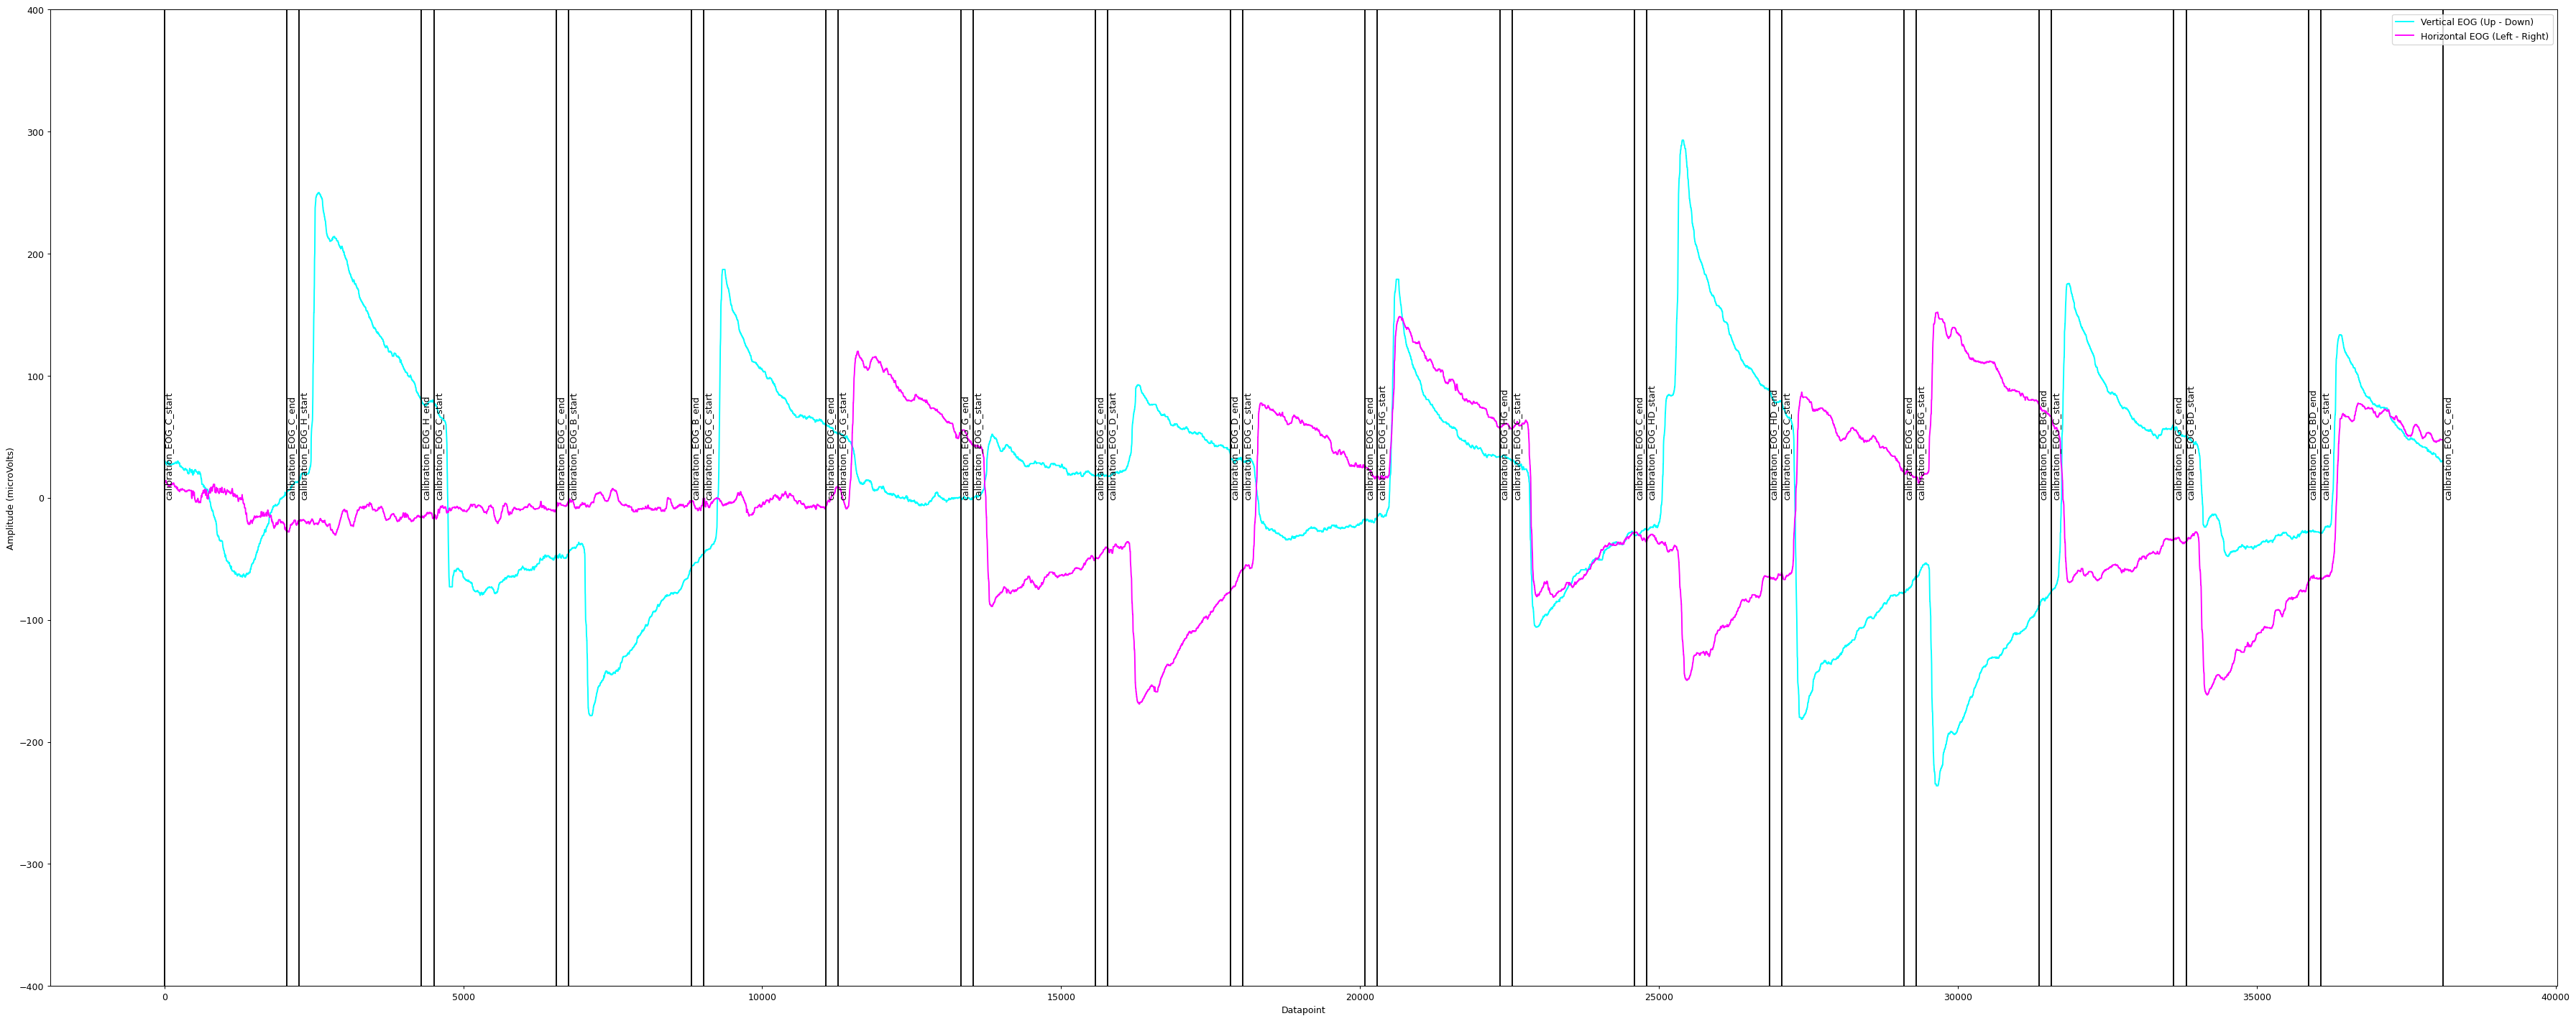

In [82]:
verticalEogDenoised = ndimage.median_filter(verticalEOG, size = 100)
horizontalEogDenoised = ndimage.median_filter(horizontalEOG, size = 100)

# sos = signal.butter(10, [5, 10], 'bandstop', fs=freqSample, output='sos')
# verticalEogDenoisedF = signal.sosfilt(sos, verticalEogDenoised)
# horizontalEogDenoisedF = signal.sosfilt(sos, horizontalEogDenoised)

plotVertHorEOG(verticalEogDenoised, horizontalEogDenoised, triggerStart=calibrationStart, triggerEnd=calibrationEnd,  mode='both', triggerCsv=triggerCsv)

### Reading .csv file with the labels for the triggers. 
These triggers represent the start and the end points of parts of the experiment.

In the following table, it is explained the meaning of each trigger.

| Meaningful Labels  | Description |
| :----------------: | :----------------: |
| **calibration_EOG_C_start** | Start of a calibration movement in a certain direction |
| C, H, B, G, D | Center, Haut, Bas, Gauche, Droite |
| calibration_EOG_C_end | End of a calibration movement |
| S_CF_start | Start of Cross Fixation (CF) for the Semantic (S) Questions round |
| S\_Q\_start\_&\_CF\_end | Start of Semantic (S) Question and Cross Fixation (CF) end |
| S_L_start or S_L_end | Analysis of letter's roundness by subject (8 or more of these in a row) |
| **S_access** | Subject acesses memories to answer previous question |
| **S_visualization** | Time to recall more details of that memory in order to answer it better |
| S_debriefing | Subject answers question. (Very noisy) |
| S, A, V | Semantic, Autobiographical, Visual Task |
| V_image | Subject analyses image to defrief it afterwards, instead of acess and visualization |

The labels in **bold** are the ones that are the most important for this eye movement project.

# Saccade Detection

This section is dedicated to using several algorithms for saccade detection:
1. Continuous Wavelet Transform - Saccade Detection based on article: Eye Movement Analysis for Activity Recognition Using Electrooculography
2. other methods...


### CWT-SD Mexican Hat Wavelet

In [93]:
verticalEOG = verticalEogDenoised
horizontalEOG = horizontalEogDenoised

coefVertMexHat, freqsVertMexHat = pywt.cwt(verticalEOG, 30, 'mexh')
coefHoriMexHat, freqsHoriMexHat = pywt.cwt(horizontalEOG, 30, 'mexh')

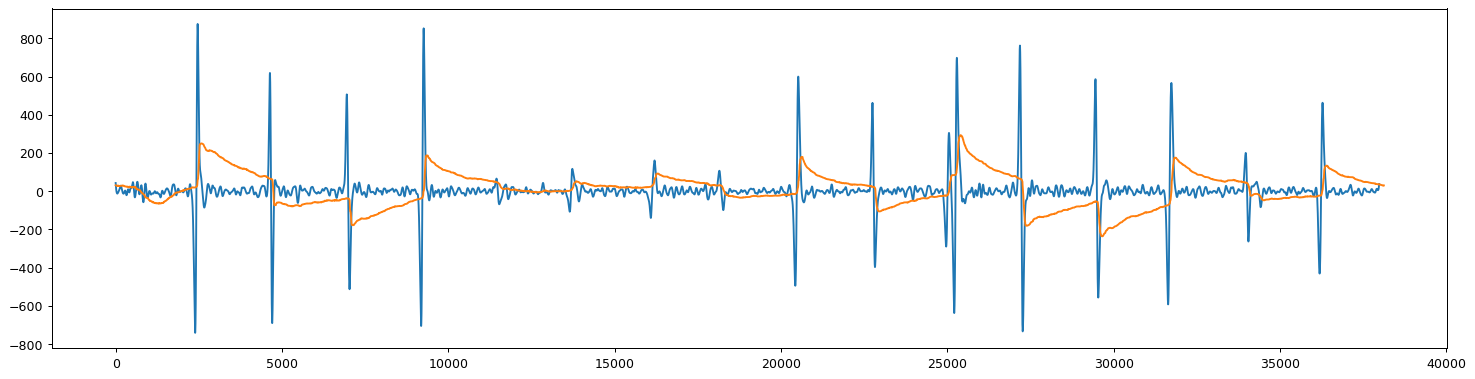

In [94]:
plt.figure(figsize=(20, 5), dpi=90)
coefVertMexHat1 = np.reshape(coefVertMexHat, (len(coefVertMexHat[0]),1))
coefVertMexHat2 = preProcessing.zeroPadArtifacts(coefVertMexHat1, 70)
plt.plot(coefVertMexHat2*2)
plt.plot(verticalEOG)
plt.show()

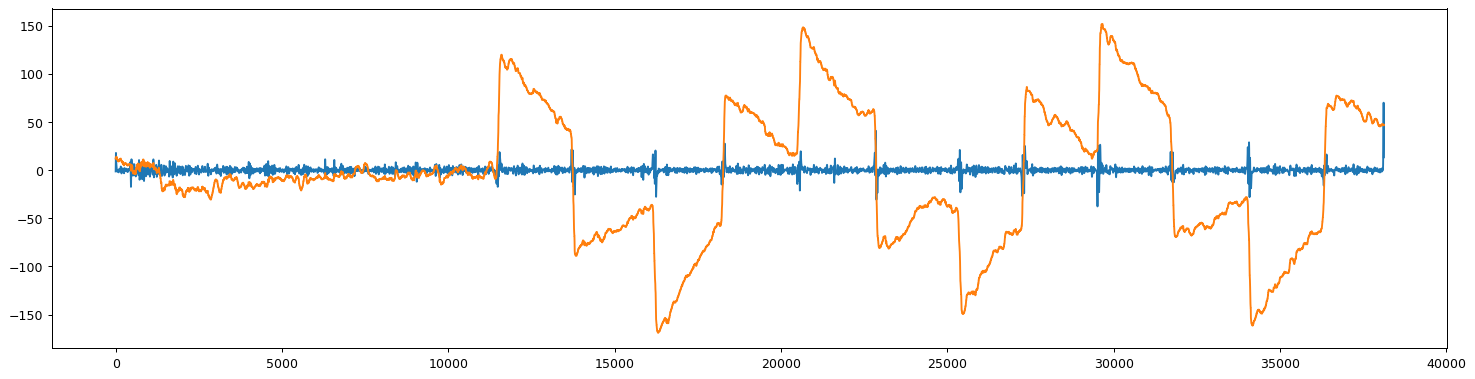

In [90]:
plt.figure(figsize=(20, 5), dpi=90)
coefHoriMexHat1 = np.reshape(coefHoriMexHat, (len(coefHoriMexHat[0]),1))
plt.plot(coefHoriMexHat1)
plt.plot(horizontalEOG)
plt.show()

### DWT-SD Haar Wavelet

In [91]:
coefVertHaar, freqsVertHaar = pywt.dwt(verticalEOG, 'haar',)
coefHoriHaar, freqsHoriHaar = pywt.dwt(horizontalEOG, 'haar',)

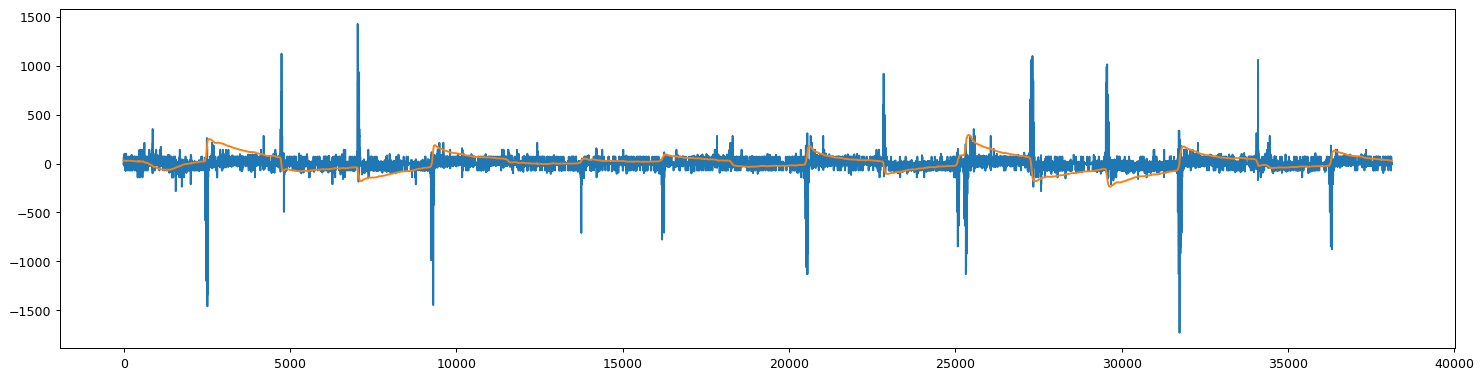

In [92]:
plt.figure(figsize=(20, 5), dpi=90)
freqsVertHaar1 = signal.resample(freqsVertHaar, len(freqsVertHaar)*2)
plt.plot(freqsVertHaar1*200)
plt.plot(verticalEOG)
plt.show()

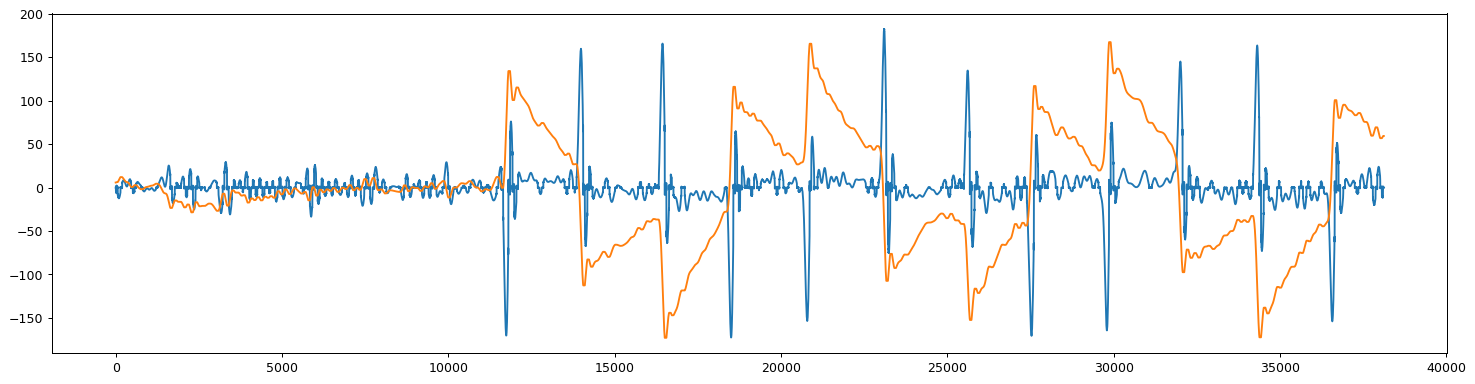

In [80]:
plt.figure(figsize=(20, 5), dpi=90)
freqsHoriHaar1 = signal.resample(freqsHoriHaar, len(freqsHoriHaar)*2)
plt.plot(freqsHoriHaar1*200)
plt.plot(horizontalEOG)
plt.show()

### CWT-SD Other Wavelets